In [236]:
import pandas as pd
from geopy.geocoders import Nominatim
import requests
import json, urllib
from scipy.stats import skew

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sb
import mpl_toolkits
from mpl_toolkits.basemap import Basemap,cm
import matplotlib.pyplot as plt
import numpy as np
import time
import operator# rank the dictionary
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.cross_validation import cross_val_score


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline
warnings.filterwarnings('ignore')
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12


In [276]:
house_data = pd.read_csv('/Users/Lucinda/Downloads/Renthop_rent_house_data.csv')

In [277]:
house_data.shape

(61725, 16)

### Data Clean for the Raw Data that Scraped from Renthop Website

#### Split "Amenities" Column to specific Propety Info and Label with 0 or 1

In [279]:
feature_value = house_data.iloc[:,1]
feature_lst = []
for i in range(len(feature_value)):
    feature_lst += feature_value[i].split("'")
print(len(feature_value)) # all features

61725


In [280]:
# see the frequency of each feature
import collections
def most_common(lst):
    features = collections.Counter(lst)
    feature_value = features.keys()
    frequency = features.values()
    data = [('feature_value', feature_value),
            ('frequency', frequency),]    
    df = pd.DataFrame.from_items(data)
    return df.sort_values(by = 'frequency', ascending = False)

Top60_common_features = most_common(feature_lst)['feature_value'][3:55]

In [281]:
def newColumn(name,df,series):
    feature = pd.Series(0,df.index,name = name)# data : 0
    for row,word in enumerate(series):
        if name in word:
            feature.iloc[row] = 1
    df[name] = feature # feature : series ; value in series : 1 or 0
    return df

# select features based on frequency
facilities = Top60_common_features
for name in facilities:
    house_data = newColumn(name, house_data, house_data['Amenities'])



#### Use the Most Precise Neighborhood Name 

In [282]:
colsest_neighborhoods =[]
neighborhooh_range = house_data['neighborhoods'].tolist()

for i in range(len(neighborhooh_range)):
    try:
        colsest_neighborhoods.append(neighborhooh_range[i].split(',')[0])
    except:   
        colsest_neighborhoods.append('NA')
    
house_data['colsest_neighborhoods'] = colsest_neighborhoods

#### Remove $ signs and commas in Price and Median_Price 

In [283]:
for col_name in ['price','median_price']:#, 'median_price'
    house_data[col_name] = house_data[col_name].str.replace('$', '')
    house_data[col_name] = house_data[col_name].str.replace(',', '')
    house_data[col_name] = house_data[col_name].astype(float)
   

#### Drop rows with '*'  and '  'in bedroom and bathroom and change the type from str to int

In [284]:
house_data = house_data[house_data.bedroom != '*']
house_data = house_data[house_data.bedroom != ' ']
house_data['bedroom'] = house_data['bedroom'].astype(int)

house_data['bathroom'] = house_data['bathroom'].astype(int)

#### Change the Order of Columns, Making 'Price' in the last one

In [285]:
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]
house_data = change_column_order(house_data, 'price', house_data.shape[1])

In [286]:
house_data.drop(['pos','Amenities', 'Unnamed: 0', 'description','expert','photo','neighborhoods','street_address','transportation'], axis = 1, inplace = True, errors = 'ignore')

In [287]:
house_data.head()

,No Fee,bathroom,bedroom,hopscore,listing_id,median_price,num_transportation,Elevator,Cats Allowed,Dogs Allowed,...,Live In Super,Storage Facility,Terrace,Wheelchair Access,Garden/Patio,Private Outdoor Space,One Month Free,Reduced Fee,colsest_neighborhoods,price
0,1,1,1,100.0,8988102,3150.0,17,1,0,0,...,0,0,0,0,0,0,0,0,Gramercy Park,3100.0
1,1,4,4,100.0,8943717,4900.0,7,1,0,0,...,0,0,0,0,0,0,0,0,Yorkville,4700.0
2,0,1,1,100.0,7814425,3800.0,8,1,1,1,...,0,1,0,0,0,1,0,1,Carnegie Hill,2995.0
3,1,3,3,100.0,8238442,4275.0,17,1,1,1,...,0,0,0,0,0,0,0,0,Gramercy Park,4000.0
4,1,1,1,100.0,8554239,0.0,12,1,1,1,...,0,0,0,0,0,1,0,0,Gramercy Park,1500.0


### Data Explore Anlayis

Decending Correlation Matrix

In [288]:
corr_matx = house_data.select_dtypes(include=['float64','int64']).iloc[:,1:].corr()

In [289]:
#make a rank of the corelations
corr_matrix = corr_matx.iloc[:,-1].to_dict()

In [290]:
sorted_cor = sorted(corr_matrix.items(), key = operator.itemgetter(1), reverse = True) 

In [291]:
df_corr = pd.DataFrame(sorted_cor, columns = ['feature', 'correlation'])

In [319]:
df_corr.head(10)

,feature,correlation
0,price,1.000000
1,median_price,0.725895
2,bedroom,0.503143
3,bathroom,0.503143
4,Laundry in Unit,0.188277
5,Doorman,0.185312
6,Elevator,0.146504
7,Swimming Pool,0.130315
8,Dining Room,0.124752
9,Fitness Center,0.121907


#### Main neighours takes 50% rental houses in NYC, some small neighourhoods have only 1 avaliable house, therefore they show nothing on the plot.
Financial District                      5865
Hell's Kitchen                          5038
Upper East Side                         4326
Yorkville                               3779
Upper West Side                         3202
Chelsea                                 2486
Murray Hill                             2474
West Village                            2046
Rose Hill                               1785
East Village                            1777
Turtle Bay                              1584
Lincoln Square                          1376
Alphabet City                           1239
Manhattan Valley                        1154
Theater District                        1111
Gramercy Park                           1098
Williamsburg                            1013

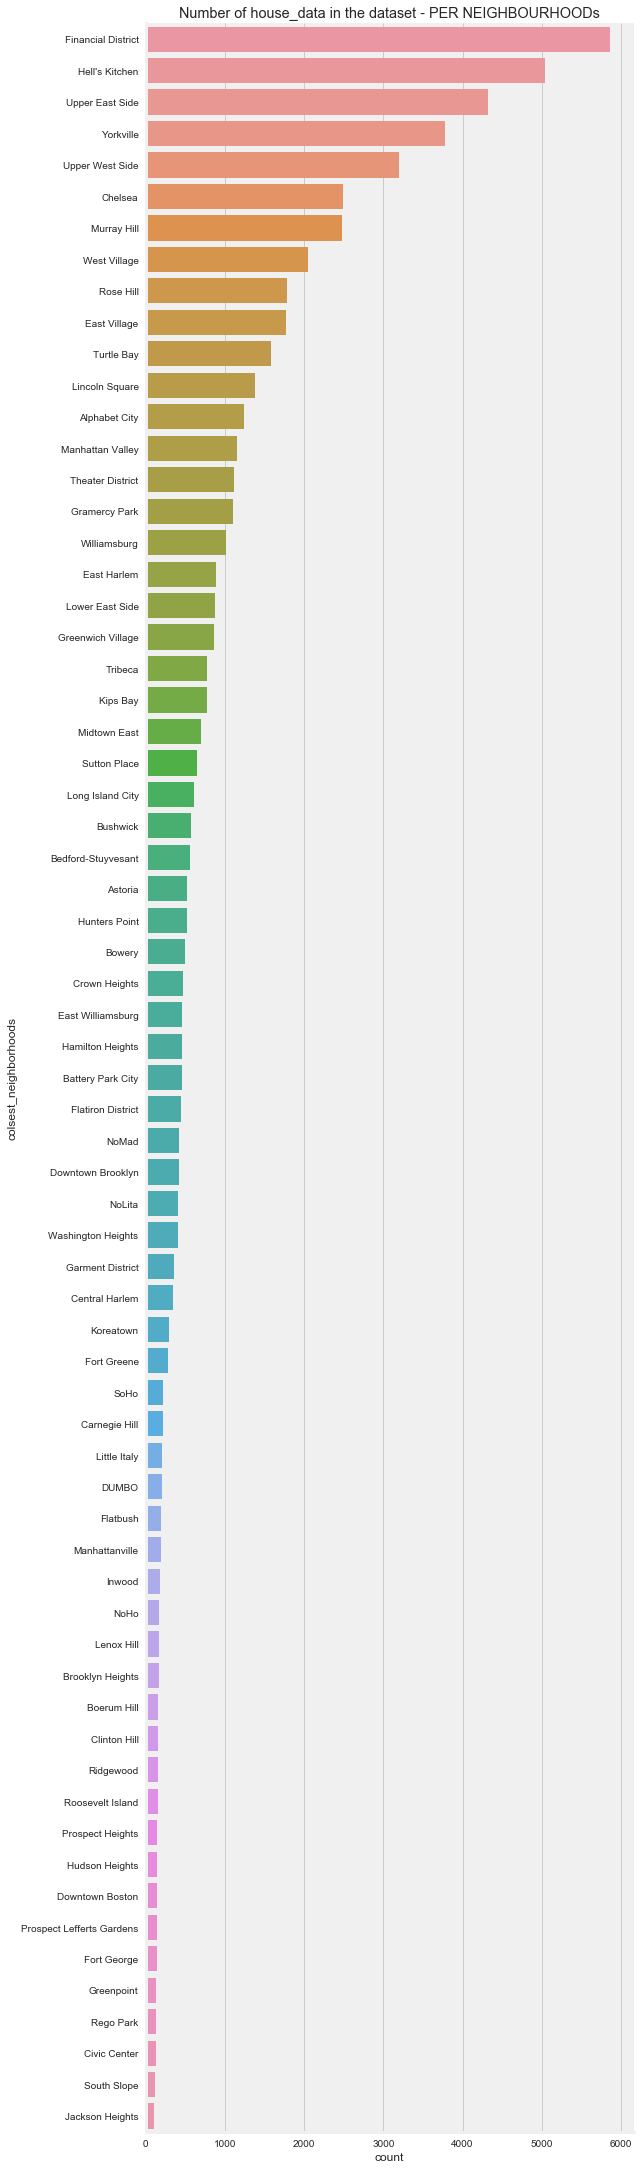

In [333]:
count_by_neib = house_data_filtered.groupby('colsest_neighborhoods',
                                             as_index=False).count().sort_values(by='bedroom',
                                                                            ascending=False)
count_by_neib['count'] = count_by_neib['bedroom']

count_by_neib = count_by_neib[count_by_neib['count']>100]

sb.factorplot(data=count_by_neib, y='colsest_neighborhoods', x='count', 
            kind='bar', order=count_by_neib.colsest_neighborhoods, size=30, aspect=0.3)

plt.title('Number of house_data in the dataset - PER NEIGHBOURHOODs');


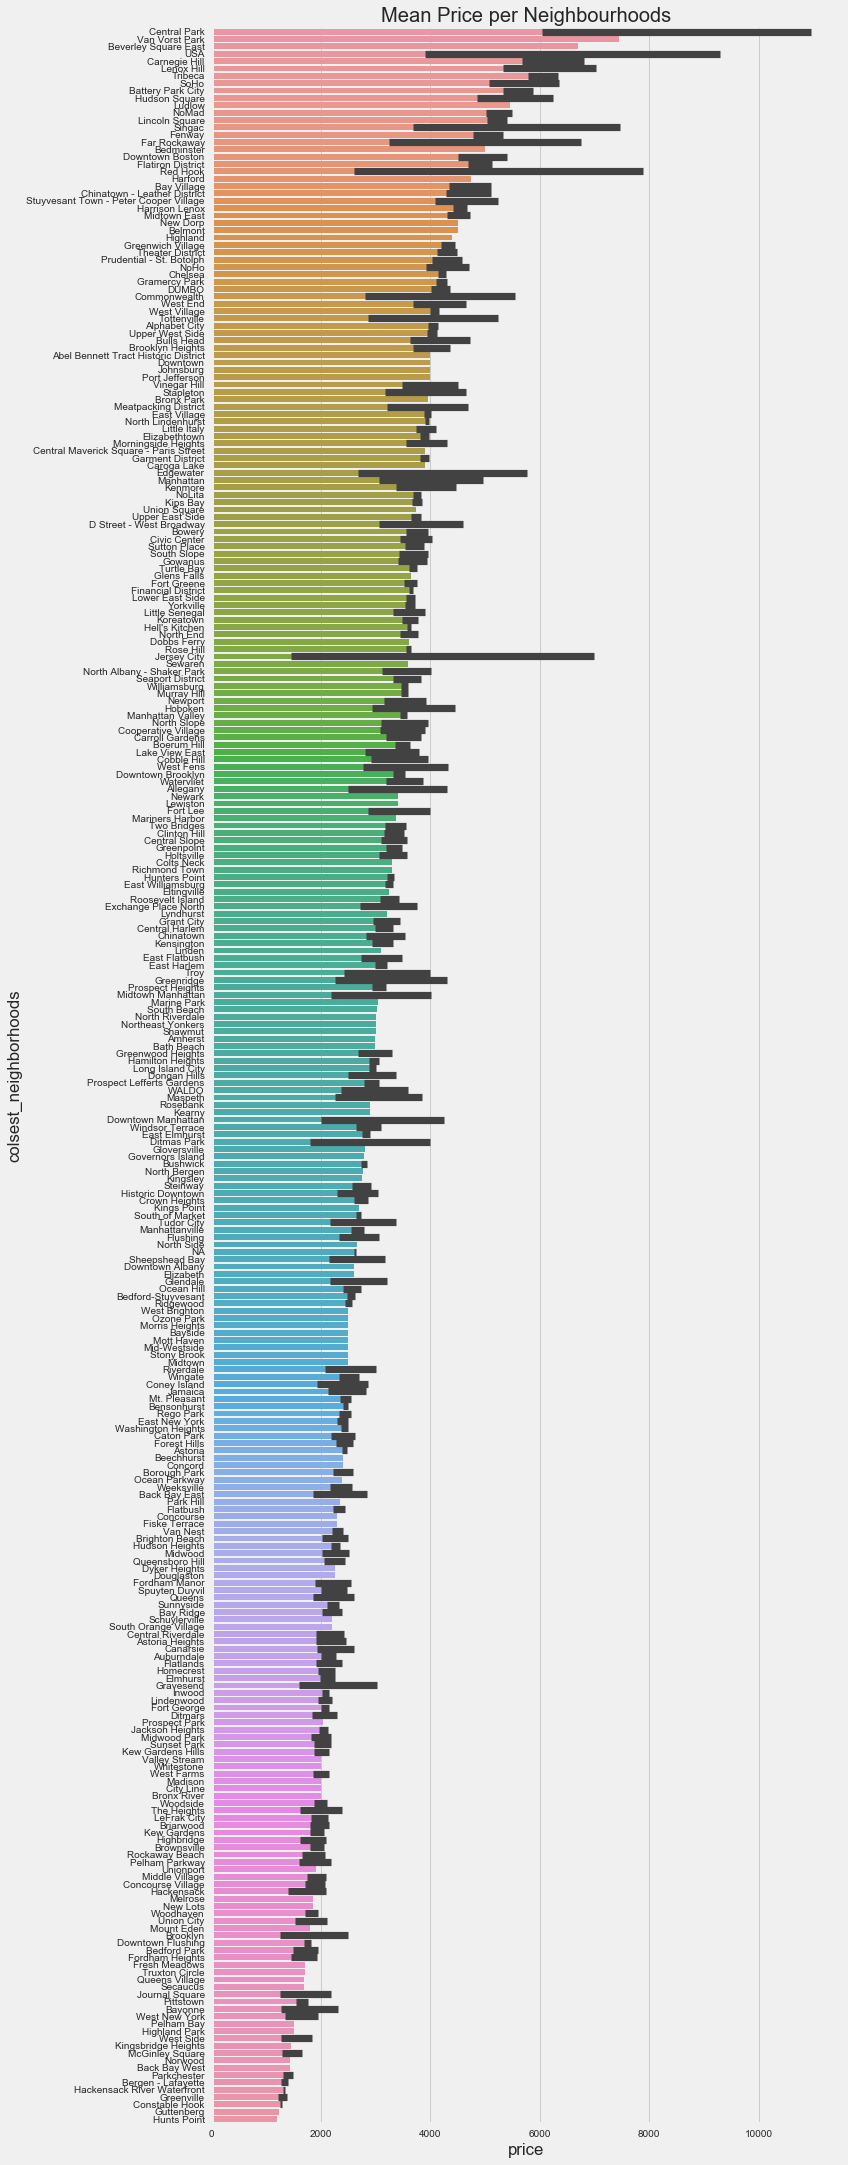

In [19]:
house_data_filtered = house_data.copy()

price_by_neib = house_data_filtered.groupby('colsest_neighborhoods',
                                         as_index=False).mean().sort_values(by='price',
                                                                            ascending=False)

sb.factorplot(data=house_data_filtered, y='colsest_neighborhoods', x='price', 
              kind='bar', order=price_by_neib.colsest_neighborhoods, size=30, aspect=0.3)

plt.title('Mean Price per Neighbourhoods')



#### Explore Neighbourhoods vs House Prices vs House Numbers

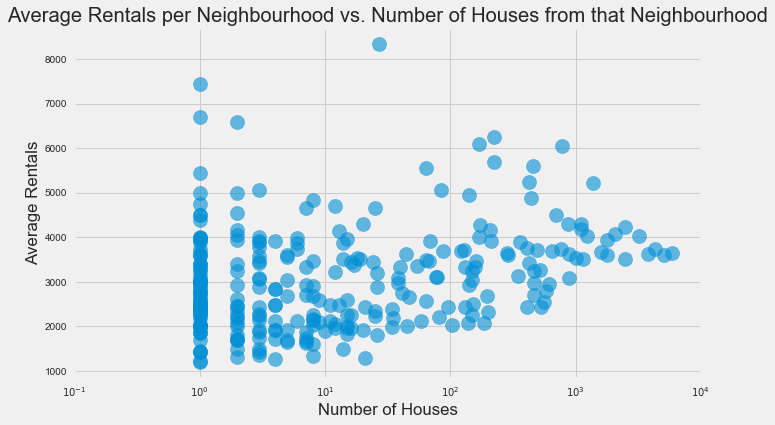

In [48]:
price_and_count = price_by_neib.merge(count_by_neib.ix[:, ['colsest_neighborhoods','count']],
                                        on='colsest_neighborhoods')

plt.figure(figsize=[10,6])
plt.scatter(price_and_count['count'], price_and_count.price, s=200, alpha=0.6)
plt.xscale('log')
plt.xlabel('Number of Houses')
plt.ylabel('Average Rentals')
plt.xlim([0.1, 1e4])
plt.title('Average Rentals per Neighbourhood vs. Number of Houses from that Neighbourhood');


Conclusion: The average rentals per neighbourhood is obviously influenced by the "law of small samples" and and we can see that the average values converge as the "sample size" increases.

#### Price exploration
#### Price distribution


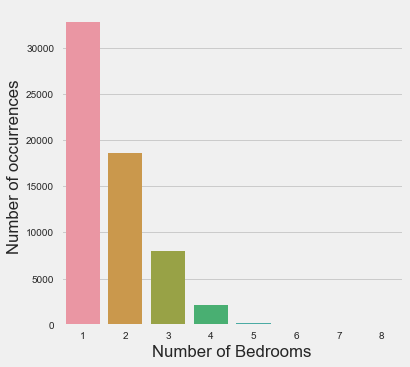

In [85]:
### Bedrooms graphs
fig = plt.figure(figsize=(12,12))
### Number of occurrences
sb.countplot(house_data.bedroom,ax = plt.subplot(221));
plt.xlabel('Number of Bedrooms');
plt.ylabel('Number of occurrences');



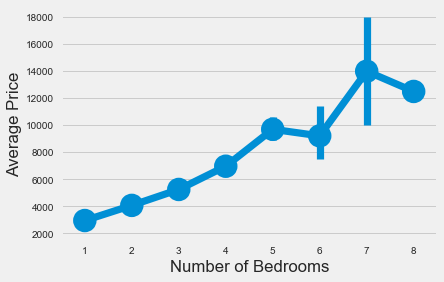

In [93]:
### Average interest for every number of bedrooms
sb.pointplot(x="bedroom", y="price", data=house_data);
plt.xlabel('Number of Bedrooms');
plt.ylabel('Average Price');


Show point estimates and confidence intervals using scatter plot glyphs.
 how the relationship between levels of one categorical variable changes across levels of a second categorical variable. The lines that join each point from the same hue level allow interactions to be judged by differences in slope, which is easier for the eyes than comparing the heights of several groups of points or bars.



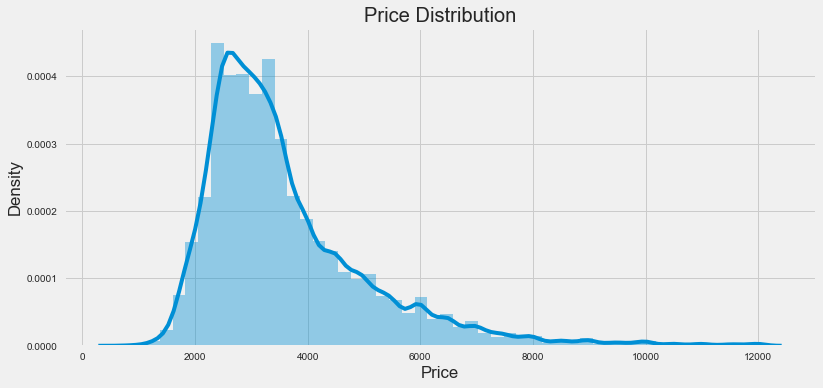

In [96]:
### Price exploration
fig = plt.figure(figsize=(12,12))
### Price distribution
sb.distplot(house_data.price[house_data.price<=house_data.price.quantile(0.99)], ax=plt.subplot(211));
plt.xlabel('Price');
plt.ylabel('Density');
plt.title('Price Distribution')


### Data Processing for Machine Learning

* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more  normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111836250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12aa4ea90>]], dtype=object)

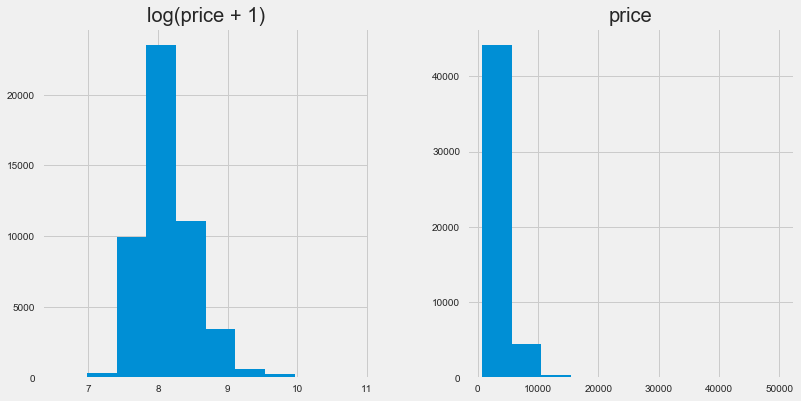

In [207]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"log(price + 1)":np.log1p(y_train["price"]),"price":y_train["price"]})
prices.hist()


In [293]:
#log transfrom the target
house_data["price"] = np.log1p(house_data['price'])


In [294]:
# log transform skewed numeric features
numeric_features = house_data.dtypes[house_data.dtypes != 'object'].index

skewed_features = house_data[numeric_features].apply(lambda x: skew(x.dropna())) #datafram.dropna()
skewed_features = skewed_features[skewed_features> 0.75]
skewed_features = skewed_features.index

house_data[skewed_features] = np.log1p(house_data[skewed_features])

In [296]:
#Get Dummies for the Neighborhoods
house_with_dummies= pd.get_dummies(house_data, prefix='Neighborhoods_', columns=['colsest_neighborhoods'])


In [300]:
#filling Na's with the mean of the column
house_with_dummies = house_with_dummies.fillna(house_with_dummies.mean())

In [301]:
#Split Train and Test Dataset  80%-20%

y = house_with_dummies['price']
house_with_dummies.drop('price', axis = 1, inplace = True, errors = 'ignore')

X_train, X_test, y_train, y_test  = train_test_split(house_with_dummies, y,test_size=0.2,random_state=42)

#### XGBoost

In [305]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

In [306]:
parmas = {"max_depth" : 2, "eta": 0.1}


In [310]:
model_xgb = xgb.XGBRegressor(n_estimators= 5000, max_depth= 3, learning_rate= 0.1,
                            gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                              nthread = 4,seed = 0)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bytree=0.8, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1,
       n_estimators=5000, nthread=4, objective='reg:linear', seed=0,
       silent=True, subsample=0.8)

(colsample_bylevel has no effect if num_row > 2**15 and tree_method=approx )

In [311]:
xgb_preds = np.expm1(model_xgb.predict(X_test))

In [317]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model,X_train,y_train, scoring = 'neg_mean_squared_error', cv = 5))
    return(rmse)

In [318]:
cv_xgb = rmse_cv(model_xgb)
print("Mean: ", cv_xgb.mean())
print("Min: ", cv_xgb.min())

('Mean: ', 0.016997796402055045)
('Min: ', 0.016683434380609593)
